# NFL Big Data Bowl - Feature Engineering v1
-------------------
TheNerdyCat <br>
27 Nov 2019 Deadline


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import seaborn as sns

import kaggle
import math
import datetime
import random

from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split
#from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import gc
import optuna

from sklearn.metrics import mean_absolute_error

import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]
pd.options.display.max_columns = 100

In [32]:
train_df = pd.read_csv("../input/nfl-big-data-bowl-2020/train.csv", low_memory=False)

In [33]:
Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

# from https://www.kaggle.com/bgmello/neural-networks-feature-engineering-for-the-win
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in train_df['PossessionTeam'].unique():
    map_abbr[abb] = abb
    
    
def uid_aggregation(comb, main_columns, uids, aggregations):
    X = pd.DataFrame()
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = comb[[col, main_column]]
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                X[new_col_name] = comb[col].map(temp_df)
                del temp_df
                gc.collect()
    return X

In [34]:
def preprocess(df, labelEncoders=None):#

    def clean_position(pos):
        if pos == 'SAF':
            return 'DB'
        if pos == 'S':
            return 'DB'
        elif pos == 'OG':
            return 'G'
        elif pos == "OT":
            return 'T'
        else:
            return pos
    
    def clean_offenceformation(of):
        if of == "SHOTGUN":
            return 9
        elif of == "SINGLEBACK":
            return 8
        elif of == "JUMBO":
            return 6
        elif of == "PISTOL":
            return 5
        elif of == "I_FORM":
            return 4
        elif of == "ACE":
            return 3
        elif of ==  "WILDCAT":
            return 2
        elif of == "EMPTY":
            return 1
        else: 
            return 7
    
    def create_generalposition(pos):
        if pos == 'SS' or pos == 'FS' or pos == 'CB' or pos == 'DB':
            return 'DB'
        elif pos == 'DE' or pos == 'DT' or pos == 'DL':
            return 'DL'
        elif pos == 'ILB' or pos == 'OLB' or pos == 'MLB' or pos == 'LB':
            return 'LB'
        elif pos == 'WR':
            return 'WR'
        elif pos == 'TE':
            return 'TE'
        elif pos == 'T' or pos == 'G' or pos == 'C' or pos == 'NT' or pos == 'OL':
            return 'OL'
        elif pos == 'QB' or pos == 'RB' or pos == 'FB' or pos == 'HB' or pos == 'TB' or pos == 'WB':
            return 'OB'
        else:
            return 'Other'

    def utc2sec(x):
        return int(x.split("-")[2].split(":")[2].split(".")[0])
    def timesnap2date(x):
        day = x.split("T")[0]
        return day
    def timesnap2day(x):
        days = x.split("-")
        return 365 * int(days[0]) + 30 * int(days[1]) + int(days[2][:2])
    def gameclock2secs(x):
        clock = x.split(":")
        return (60 * int(clock[0])) + int(clock[1])        
        
    def group_stadium_types(stadium):
        outdoor = [
            'Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 'Outdor', 'Ourdoor', 
            'Outside', 'Outddors','Outdoor Retr Roof-Open', 'Oudoor', 'Bowl'
            ]
        indoor_closed = [
            'Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed',
            'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed',
        ]
        indoor_open   = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
        dome_closed   = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
        dome_open     = ['Domed, Open', 'Domed, open']
        if stadium in outdoor:
            return 0 #'outdoor'
        elif stadium in indoor_closed:
            return 3 # 'indoor closed'
        elif stadium in indoor_open:
            return 2 #'indoor open'
        elif stadium in dome_closed:
            return 4 #'dome closed'
        elif stadium in dome_open:
            return 1 #'dome open'
        else:
            return 5 #'unknown'
        
    def group_game_weather(weather):
        rain = [
            'Rainy', 'Rain Chance 40%', 'Showers',
            'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
            'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain'
        ]
        overcast = [
            'Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
            'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
            'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
            'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
            'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
            'Partly Cloudy', 'Cloudy'
        ]
        clear = [
            'Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
            'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
            'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
            'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
            'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
            'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny'
        ]
        snow  = ['Heavy lake effect snow', 'Snow']
        none  = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']
        if weather in rain:
            return -1 #'rain'
        elif weather in overcast:
            return 1 #'overcast'
        elif weather in clear:
            return 2 #'clear'
        elif weather in snow:
            return -2 #snow'
        elif weather in none:
            return 0 #'none'        
        
    def clean_wind_speed(windspeed):
        """
        This is not a very robust function,
        but it should do the job for this dataset.
        """
        ws = str(windspeed)
        # if it's already a number just return an int value
        if ws.isdigit():
            return int(ws)
        # if it's a range, take their mean
        if '-' in ws:
            return (int(ws.split('-')[0]) + int(ws.split('-')[1]))/2
        # if there's a space between the number and mph
        if ws.split(' ')[0].isdigit():
            return int(ws.split(' ')[0])
        # if it looks like '10MPH' or '12mph' just take the first part
        if 'mph' in ws.lower():
            return int(ws.lower().split('mph')[0])
        else:
            return 0   
            
    def clean_wind_direction(wind_direction):
        wd = str(wind_direction).upper()
        if wd == 'N' or 'FROM S' in wd:
            return 90 #'north'
        if wd == 'S' or 'FROM N' in wd:
            return 270 #'south'
        if wd == 'W' or 'FROM E' in wd:
            return 180 #'west'
        if wd == 'E' or 'FROM W' in wd:
            return 0 #'east'
        if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
            return 45 #'north east'
        if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
            return 135 #'north west'
        if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
            return 315 #'south east'
        if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
            return 225 #'south west'
        if 'NW' in wd or 'NORTHWEST' in wd:
            return 135 #'north west'
        if 'NE' in wd or 'NORTH EAST' in wd:
            return 45 #'north east'
        if 'SW' in wd or 'SOUTHWEST' in wd:
            return 225 #'south west'
        if 'SE' in wd or 'SOUTHEAST' in wd:
            return 315 #'south east'            
            
    def birthday2day(x):
        days = x.split("/")
        return 30 * int(days[0]) + int(days[1]) + 365 * int(days[2])
    
    def height2inch(x):
        height = x.split("-")
        return 12 * int(height[0]) + int(height[1])    
    
    
    df['ToLeft'] = df.PlayDirection == "left"
    # Match the NFLId to that play's rusher's ID
    df['IsBallCarrier'] = df.NflId == df.NflIdRusher 
    
    # New feature to show Dir in radians
    df['Dir_rad'] = np.mod(90 - df.Dir, 360) * math.pi/180.0
    df['TeamOnOffense'] = "home"
    df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    
    # IsOnOffense
    df['IsOnOffense'] = df.Team == df.TeamOnOffense 
    
    df['YardLine_std'] = 100 - df.YardLine
    df.loc[df.FieldPosition.fillna('') == df.PossessionTeam,  
              'YardLine_std'
             ] = df.loc[df.FieldPosition.fillna('') == df.PossessionTeam,  
              'YardLine']
    df['X_std'] = df.X
    df.loc[df.ToLeft, 'X_std'] = 120 - df.loc[df.ToLeft, 'X'] 
    df['Y_std'] = df.Y
    df.loc[df.ToLeft, 'Y_std'] = 160/3 - df.loc[df.ToLeft, 'Y'] 
    df['Orientation_std'] = -90 + df.Orientation
    df['Dir_std'] = df['Dir_rad']
    df.loc[df.ToLeft, 'Dir_std'] = np.mod(np.pi + df.loc[df.ToLeft, 'Dir_rad'], 2*np.pi)
    
    # Clean Position feature
    df['Position'] = df['Position'].apply(clean_position)
    
    # OffenseTeam & DefenseTeam
    df = df.rename(columns = {'PossessionTeam':'OffenseTeam'}) 
    df['DefenseTeam'] = df['VisitorTeamAbbr']
    df.loc[df.TeamOnOffense == 'away', 'DefenseTeam'] = df['HomeTeamAbbr']
    
    # IsOffenseAtHome
    df['IsOffenseAtHome'] = True
    df.loc[df.TeamOnOffense == 'away', 'IsOffenseAtHome'] = False
    
    # OffenseScore
    df['OffenseScore'] = df['HomeScoreBeforePlay']
    df.loc[df.TeamOnOffense == 'away', 'OffenseScore'] = df['VisitorScoreBeforePlay']
    
    # DefenseScore
    df['DefenseScore'] = df['VisitorScoreBeforePlay']
    df.loc[df.TeamOnOffense == 'away', 'DefenseScore'] = df['HomeScoreBeforePlay']
    
    # IsOffenseWinning
    df['IsOffenseWinning'] = False
    df.loc[df.OffenseScore > df.DefenseScore, 'IsOffenseWinning'] = True
    
    # OffenseInOwnTerritory
    df['OffenseInOwnTerritory'] = False
    df.loc[df.FieldPosition == df.OffenseTeam, 'OffenseInOwnTerritory'] = True
    
    # OffenseRushingPosition
    play_rushers = df.loc[df.NflIdRusher == df.NflId, ['PlayId', 'Position']]
    play_rushers = play_rushers.rename(columns={'Position': 'OffenseRushingPosition'})
    df = df.merge(play_rushers, how='left', left_on='PlayId', right_on='PlayId')
    
    # OffenceFormation
    df['OffenseFormation'] = df['OffenseFormation'].apply(clean_offenceformation)
    df['OffenseFormation'] = df['OffenseFormation'].fillna(7)
    
    # NumberOfTEsOnPlay, NumberOfWRsOnPlay, NumberOfBacksOnPlay, ....
    df['GeneralPosition'] = df['Position'].apply(create_generalposition)
    # Pivot to find counts of each general position
    gen_pos_counts = df[['PlayId','GeneralPosition']].pivot_table(index='PlayId', columns='GeneralPosition', 
                                                                  aggfunc=len, fill_value=0)
    gen_pos_counts = gen_pos_counts.rename(columns = 
                          {'DB':'NumberOfDBsOnPlay', 'DL':'NumberOfDLinemenOnPlay', 
                           'LB':'NumberOfLBsOnPlay', 'OB':'NumberOfBacksOnPlay',
                           'OL':'NumberOfOLinemenOnPlay', 'TE':'NumberOfTEsOnPlay',
                           'WR':'NumberOfWRsOnPlay'})
    df = df.merge(gen_pos_counts, how='left', left_on='PlayId', right_on='PlayId')
    
    # DefendersInTheBox
    df['DefendersInTheBox'] = df['DefendersInTheBox'].fillna(df['DefendersInTheBox'].median())
    
    # TimeBetweenSnapHandoff, Month, ...
    df['TimeBetweenSnapHandoff'] = df['TimeHandoff'].apply(utc2sec) - df['TimeSnap'].apply(utc2sec)
    df['MatchDay'] = df['TimeSnap'].apply(timesnap2day)
    df['DayOfYear'] = pd.to_datetime(df['TimeSnap'].apply(timesnap2date)).dt.dayofyear
    df['DayOfWeek'] = pd.to_datetime(df['TimeSnap'].apply(timesnap2date)).dt.dayofweek
    df['MonthOfYear'] = df['TimeSnap'].apply(lambda x : int(x[5:7]))
    df['Morning'] = df['TimeSnap'].apply(lambda x : 1 if (int(x[11:13]) >=0 and int(x[11:13]) <12) else 0)
    df['Afternoon'] = df['TimeSnap'].apply(lambda x : 1 if (int(x[11:13]) <18 and int(x[11:13]) >=12) else 0)
    df['Evening'] = df['TimeSnap'].apply(lambda x : 1 if (int(x[11:13]) >= 18 and int(x[11:13]) < 24) else 0)

    # QuarterGameSecs, TotalGameSecsPlayed, HalfGameSecs
    df['QuarterGameSecs'] = df['GameClock'].apply(gameclock2secs)
    df['TotalGameSecsPlayed'] = (900 - df['QuarterGameSecs']) + ((df['Quarter'] - 1) * 900)
    df['HalfGameSecsLeft'] = df['QuarterGameSecs']
    df.loc[(df['Quarter'].isin([1,3])), 'HalfGameSecsLeft'] = (900 + df['QuarterGameSecs'])
    
    # IsInEngland
    df['IsInEngland'] = df["Location"].str.lower().map(lambda x: True if "london" in x else False)
    
    # StadiumType
    # from https://www.kaggle.com/code1110/optimizing-lightgbm-hyperparameters
    df['StadiumType'] = df['StadiumType'].apply(group_stadium_types)
    
    # Turf
    # from https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-649087
    df['Turf'] = df['Turf'].map(Turf)
    df['Turf'] = df['Turf'].map({"Natural": 0,"Artificial": 1})
    
    # GameWeather
    # https://www.kaggle.com/code1110/optimizing-lightgbm-hyperparameters
    df['GameWeather'] = df['GameWeather'].apply(group_game_weather)
        
    # Temperature 
    df['Temperature'] = df['Temperature'].fillna(df['Temperature'].median())
    
    # Humidity
    df['Humidity'] = df['Humidity'].fillna(df['Humidity'].median())
    
    # WindSpeed
    df['WindSpeed'] = df['WindSpeed'].apply(clean_wind_speed)
    
    # WindDirection
    # from https://www.kaggle.com/code1110/optimizing-lightgbm-hyperparameters
    df['WindDirection'] = df['WindDirection'].apply(clean_wind_direction)
    df['WindDirection'] = 2 * np.pi * (90 - df['WindDirection']) / 360
    
    # Team
    df['Team'] = df['Team'].map({"home": 0, "away": 1})
    
    # Dir
    df["Dir"] = np.mod(90 - df["Dir"].values, 360)
    
    # PlayerBirthDate
    df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(birthday2day)
    
    # PlayerAge
    df['PlayerAge'] = df['MatchDay'] - df['PlayerBirthDate']
    
    # PlayDirection
    df['PlayDirection'] = df['PlayDirection'].map({'right': 1, 'left': -1})
    
    # PlayerWeight
    df['PlayerHeight'] = df['PlayerHeight'].apply(height2inch)
    
    # PlayerBMI
    df['PlayerBMI'] = df['PlayerWeight'] / df['PlayerHeight']
    
    # SecondsNeedToFirstDown
    # from https://www.kaggle.com/ryches/model-free-benchmark
    df['SecondsNeedToFirstDown'] = (df['Distance']*0.9144) / (df['Dis'].values + 0.01)
    
    # SecondsNeedToYardLine
    # from https://www.kaggle.com/ryches/model-free-benchmark
    df['SecondsNeedToYardLine'] = (df['YardLine']*0.9144) / (df['Dis'].values + 0.01)
    
    # DefendersInTheBox_vs_Distance
    # from https://www.kaggle.com/ryches/model-free-benchmark
    df['DefendersInTheBox_vs_Distance'] = df['DefendersInTheBox'] / df['Distance']
    
    # Start
    # from https://www.kaggle.com/sryo188558/cox-proportional-hazard-model
    df["Start"] = df["YardLine"]
    df.loc[(df["OffenseInOwnTerritory"] == 1) & (df["PlayDirection"] == 1), "Start"] = df.loc[(df["OffenseInOwnTerritory"] == 1) & (df["PlayDirection"] == 1), 
                                                                                       "YardLine"] + 10
    df.loc[(df["OffenseInOwnTerritory"] == 1) & (df["PlayDirection"] == -1), "Start"] = 120 - df.loc[(df["OffenseInOwnTerritory"] == 1) & (df["PlayDirection"] == -1), 
                                                                                       "YardLine"] - 10
    df.loc[(df["OffenseInOwnTerritory"] == 0) & (df["PlayDirection"] == 1), "Start"] = 120 - df.loc[(df["OffenseInOwnTerritory"] == 0) & (df["PlayDirection"] == 1), 
                                                                                       "YardLine"] - 10
    df.loc[(df["OffenseInOwnTerritory"] == 0) & (df["PlayDirection"] == -1), "Start"] = df.loc[(df["OffenseInOwnTerritory"] == 0) & (df["PlayDirection"] == -1), 
                                                                                       "YardLine"] + 10
    # Orientation 
    df['Orientation'] = 2 * np.pi * (90 - df['Orientation']) / 360
    
    # locX
    df['locX'] = (df['X'].values - df['Start'].values) * df['PlayDirection'].values
    
    # locY
    df['locY'] = df['Y'].values - 53.3 / 2
    
    # velX
    df['velX'] = df['S'].values * np.cos(df['Orientation'].values) * df['PlayDirection'].values
    
    # velY
    df['velY'] = df['S'].values * np.sin(df['Orientation'].values)
    
    # accX
    df['accX'] = df['A'].values * np.cos(df['Orientation'].values) * df['PlayDirection'].values
    
    # accY
    df['accY'] = df['A'].values * np.sin(df['Orientation'].values)
    
    # Aggregations by NflId (each player)
    i_cols = ['HomeScoreBeforePlay','VisitorScoreBeforePlay','YardLine']
    uids = ['NflId']
    aggregations = ['mean','std','median', 'max', 'min']
    df_agg = uid_aggregation(df, i_cols, uids, aggregations)
    df = pd.concat([df, df_agg], axis=1)
    
    # OffenseTeam & DefenseTeam dummies
    df = pd.get_dummies(df, prefix=['OffenseTeam', 'DefenseTeam'], 
                              columns=['OffenseTeam', 'DefenseTeam'])

    X = df.select_dtypes(exclude=['object'])
    
    return X

In [35]:
train_df = preprocess(train_df)

In [36]:
print(train_df.shape)
train_df.head()

(509762, 159)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,DefendersInTheBox,PlayDirection,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,Week,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,ToLeft,IsBallCarrier,Dir_rad,IsOnOffense,YardLine_std,X_std,Y_std,Orientation_std,Dir_std,IsOffenseAtHome,OffenseScore,DefenseScore,IsOffenseWinning,OffenseInOwnTerritory,NumberOfDBsOnPlay,...,OffenseTeam_JAX,OffenseTeam_KC,OffenseTeam_LA,OffenseTeam_LAC,OffenseTeam_MIA,OffenseTeam_MIN,OffenseTeam_NE,OffenseTeam_NO,OffenseTeam_NYG,OffenseTeam_NYJ,OffenseTeam_OAK,OffenseTeam_PHI,OffenseTeam_PIT,OffenseTeam_SEA,OffenseTeam_SF,OffenseTeam_TB,OffenseTeam_TEN,OffenseTeam_WAS,DefenseTeam_ARI,DefenseTeam_ATL,DefenseTeam_BAL,DefenseTeam_BUF,DefenseTeam_CAR,DefenseTeam_CHI,DefenseTeam_CIN,DefenseTeam_CLE,DefenseTeam_DAL,DefenseTeam_DEN,DefenseTeam_DET,DefenseTeam_GB,DefenseTeam_HOU,DefenseTeam_IND,DefenseTeam_JAX,DefenseTeam_KC,DefenseTeam_LA,DefenseTeam_LAC,DefenseTeam_MIA,DefenseTeam_MIN,DefenseTeam_NE,DefenseTeam_NO,DefenseTeam_NYG,DefenseTeam_NYJ,DefenseTeam_OAK,DefenseTeam_PHI,DefenseTeam_PIT,DefenseTeam_SEA,DefenseTeam_SF,DefenseTeam_TB,DefenseTeam_TEN,DefenseTeam_WAS
0,2017090700,20170907000118,1,73.91,34.84,1.69,1.13,0.40,0.139801,272.82,496723,29,2017,35,1,3,2,0,0,2543773,9,6.0,-1,8,72,212,726009,1,0,1,2.0,63.0,77.0,8.0,-2.356194,True,False,4.761607,False,35,46.09,18.493333,-8.01,1.620015,True,0,0,False,True,6,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017090700,20170907000118,1,74.67,32.64,0.42,1.35,0.01,1.088911,251.30,2495116,97,2017,35,1,3,2,0,0,2543773,9,6.0,-1,8,75,288,726100,1,0,1,2.0,63.0,77.0,8.0,-2.356194,True,False,4.386012,False,35,45.33,20.693333,-62.39,1.244420,True,0,0,False,True,6,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017090700,20170907000118,1,74.00,33.20,1.22,0.59,0.31,1.518262,247.27,2495493,50,2017,35,1,3,2,0,0,2543773,9,6.0,-1,8,75,270,726036,1,0,1,2.0,63.0,77.0,8.0,-2.356194,True,False,4.315676,False,35,46.00,20.133333,-86.99,1.174083,True,0,0,False,True,6,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017090700,20170907000118,1,71.46,27.70,0.42,0.54,0.02,-4.708375,344.36,2506353,56,2017,35,1,3,2,0,0,2543773,9,6.0,-1,8,75,245,723782,1,0,1,2.0,63.0,77.0,8.0,-2.356194,True,False,6.010216,False,35,48.54,25.633333,269.77,2.868623,True,0,0,False,True,6,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017090700,20170907000118,1,69.32,35.42,1.82,2.43,0.16,1.350361,285.69,2530794,38,2017,35,1,3,2,0,0,2543773,9,6.0,-1,8,72,206,725512,1,0,1,2.0,63.0,77.0,8.0,-2.356194,True,False,4.986231,False,35,50.68,17.913333,-77.37,1.844638,True,0,0,False,True,6,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
rm_cols = ['index','GameId','PlayId','NflId','FieldPosition', 
          'DisplayName','NflIdRusher']

features = [c for c in train_df.columns.values if c not in rm_cols]
train_df = train_df[features]
#print(train_df.shape)
#train_df.head()

In [ ]:
# from https://www.kaggle.com/hukuda222/nfl-simple-model-using-lightgbm
train_data=np.zeros((509762//22, len(features)))
for i in tqdm.tqdm(range(0,509762,22)):
    count=0
    for c in features:
        train_data[i//22][count] = train_df[c][i]
        count+=1

In [ ]:
y_train_ = np.array([train_df["Yards"][i] for i in range(0,509762,22)])

In [ ]:
X_train = pd.DataFrame(data=train_data, columns=features)

In [ ]:
features = [f for f in features if f not in ["Yards"]]
X_train = X_train[features]

print(X_train.shape)
X_train.head()

In [ ]:
y_train = np.zeros(len(y_train_), dtype=np.float)
for i in range(len(y_train)):
    y_train[i] = (y_train_[i])

scaler = preprocessing.StandardScaler()
scaler.fit([[y] for y in y_train])
y_train = np.array([y[0] for y in scaler.transform([[y] for y in y_train])])
data = [0 for i in range(199)]
for y in y_train:
    data[int(y + 99)] += 1

## Modelling

In [ ]:
# from https://www.kaggle.com/newbielch/lgbm-regression-view
def get_cdf_df(yards_array):
    pdf, edges = np.histogram(yards_array, bins=199,
                 range=(-99,100), density=True)
    cdf = pdf.cumsum().clip(0, 1)
    cdf_df = pd.DataFrame(data=cdf.reshape(-1, 1).T, 
                            columns=['Yards'+str(i) for i in range(-99,100)])
    return cdf_df
cdf = get_cdf_df(y_train).values.reshape(-1,)
dist_to_end_train = X_train.apply(lambda x:(100 - x.loc['YardLine']) if x.loc["OffenseInOwnTerritory"]==1 else x.loc['YardLine'],axis=1)

In [ ]:
def get_score(y_pred,cdf,w,dist_to_end):
    y_pred = int(y_pred)
#     y_pred = y_pred.astype(int)
    if y_pred ==w:
        y_pred_array = cdf.copy()
    elif y_pred - w >0:
        y_pred_array = np.zeros(199)
        y_pred_array[(y_pred-w):] = cdf[:(-(y_pred-w))].copy()
    elif w - y_pred >0:
        y_pred_array = np.ones(199)
        y_pred_array[:(y_pred-w)] = cdf[(w-y_pred):].copy()
    y_pred_array[-1]=1
    y_pred_array[(dist_to_end+99):]=1
    return y_pred_array    

def get_score_pingyi1(y_pred,y_true,cdf,w,dist_to_end):
    y_pred = int(y_pred)
    if y_pred ==w:
        y_pred_array = cdf.copy()
    elif y_pred - w >0:
        y_pred_array = np.zeros(199)
        y_pred_array[(y_pred-w):] = cdf[:(-(y_pred-w))].copy()
    elif w - y_pred >0:
        y_pred_array = np.ones(199)
        y_pred_array[:(y_pred-w)] = cdf[(w-y_pred):].copy()
    y_pred_array[-1]=1
    y_pred_array[(dist_to_end+99):]=1
    y_true_array = np.zeros(199)
    y_true_array[(y_true+99):]=1
    return np.mean((y_pred_array - y_true_array)**2)


def CRPS_pingyi1(y_preds,y_trues,w,cdf,dist_to_ends):
    if len(y_preds) != len(y_trues):
        print('length does not match')
        return None
    n = len(y_preds)
    tmp = []
    for a,b,c in zip(y_preds, y_trues, dist_to_ends):
        tmp.append(get_score_pingyi1(a,b,cdf,w,c))
    return np.mean(tmp)

In [ ]:
# Initial LGB parameters are ...
lgbParams = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    "num_iterations": 1000, 
    "learning_rate": 0.05,
    "lambda_l1": 9,
    "lambda_l2": 0.9,
    "num_leaves": 42,
    "feature_fraction": 0.4,
    "bagging_fraction": 0.45,
    "bagging_freq": 7,
    "min_child_samples": 74,
    "random_state": 14
}

In [ ]:
## Visualize feature importance

# make a LightGBM dataset
trainX, testX, trainY, testY = train_test_split(X_train, y_train, test_size=0.33, random_state=14)
d_train = lgb.Dataset(trainX, trainY)
d_eval = lgb.Dataset(testX, testY, reference=d_train)

# model training
LGBmodel = lgb.train(lgbParams, d_train, valid_sets=d_eval, verbose_eval=1000)
# LGBmodel = lgb.train(lgbParams, d_train, valid_sets=d_eval, early_stopping_rounds=500, verbose_eval=1000)

# feature importance
importance = LGBmodel.feature_importance(importance_type="gain")
ranking = np.argsort(-importance)
fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(x=importance[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()

In [ ]:
features = X_train.columns.values[ranking][:30]
print(features)
X_train = X_train[features]

In [ ]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
  
    # make a LightGBM dataset
    trainX, testX, trainY, testY = train_test_split(X_train, y_train, test_size=0.33, random_state=14)
    d_train = lgb.Dataset(trainX, trainY)

    param = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 40, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    gbm = lgb.train(param, d_train)
    preds = gbm.predict(testX)
    mae = mean_absolute_error(testY, preds)
    return mae

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
lgbParams = trial.params
lgbParams['objective'] = 'regression'
lgbParams['metric'] = 'mae'
lgbParams['verbosity'] = -1
lgbParams['boosting_type'] = 'gbdt'
lgbParams["learning_rate"] = 0.01
lgbParams["num_iterations"] = 5000
lgbParams["random_state"] = 14
print(lgbParams)

In [ ]:
lgbParams = {'lambda_l1': 0.000034180869789713894, 
             'lambda_l2': 0.00000013425311506006964, 
             'num_leaves': 40, 
             'feature_fraction': 0.48320005305933245,
             'bagging_fraction': 0.8818031049495277, 
             'bagging_freq': 5, 
             'min_child_samples': 86, 
             'objective': 'regression', 
             'metric': 'mae', 
             'verbosity': -1, 
             'boosting_type': 'gbdt', 
             'learning_rate': 0.01, 
             'num_iterations': 5000, 
             'random_state': 14}

In [ ]:
n_splits = 5
seed = 14
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
y_valid = np.zeros(X_train.shape[0])
models = []

for train_idx, valid_idx in kf.split(X_train, y_train):
    trainX, trainY = X_train.iloc[train_idx, :], y_train[train_idx]
    validX, validY = X_train.iloc[valid_idx, :], y_train[valid_idx]
    
    d_train = lgb.Dataset(trainX, trainY)
    d_eval = lgb.Dataset(validX, validY, reference=d_train)
    
    LGBmodel = lgb.train(lgbParams, d_train, valid_sets=d_eval, 
                         early_stopping_rounds=500, 
                         learning_rates = lambda iter: 0.01 * (0.99 ** iter),
                         verbose_eval = 1000)
    y_valid[valid_idx] += LGBmodel.predict(validX, num_iteration=LGBmodel.best_iteration)
    models.append(LGBmodel)
gc.collect()

In [ ]:
cprs = CRPS_pingyi1(y_valid, y_train.astype(int), 4, cdf, dist_to_end_train.astype(int))
print("cprs = {}".format(cprs))

## Submission

In [ ]:
from kaggle.competitions import nflrush
env = nflrush.make_env()

In [ ]:
index = 0
for (test_df, sample_prediction_df) in tqdm.tqdm(env.iter_test()):
#     test, le = preprocess(test_df, labelEncoders=labelEncoders)
    test = preprocess(test_df)
    count=0
    dist_to_end_test = test.apply(lambda x:(100 - x.loc['YardLine']) if x.loc["OffenseInOwnTerritory"]==1 else x.loc['YardLine'],axis=1)
    test_data = np.zeros((1,len(features)))
    for c in features:
        try:
            test_data[0][count] = test[c][index]
        except:
            test_data[0][count] = np.nan
        count+=1
        
#     print(test_data)
    y_pred = np.zeros(199)        
    y_pred_p = np.sum(np.round(scaler.inverse_transform(
        [model.predict(test_data) for model in models]))) / n_splits
#     y_pred = list(get_score(y_pred_p, cdf, 4, dist_to_end_test.astype(int).values[0]))
#     y_pred = np.array(y_pred).reshape(1,199)
#     print(y_pred)
    y_pred_p += 99
    for j in range(199):
        if j>=y_pred_p+10:
            y_pred[j]=1.0
        elif j>=y_pred_p-10:
            y_pred[j]=(j+10-y_pred_p)*0.05
#             y_pred[j]=norm_cumsum[max(min(j+10-y_pred_p),0)]
#     pred_target = pd.DataFrame(index = sample_prediction_df.index, \
#                                columns = sample_prediction_df.columns, \
#                                data = y_pred)
#     env.predict(pred_target)
    env.predict(pd.DataFrame(data=[y_pred],columns=sample_prediction_df.columns))
    index += 22
env.write_submission_file()

In [37]:
train = train_df

In [38]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax
#create_football_field()

In [39]:
def get_dx_dy(radian_angle, dist):
    dx = dist * math.cos(radian_angle)
    dy = dist * math.sin(radian_angle)
    return dx, dy

def show_play(play_id, train=train):
    df = train[train.PlayId == play_id]
    fig, ax = create_football_field()
    ax.scatter(df.X, df.Y, cmap='rainbow', c=~(df.Team == 'home'), s=100)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X, rusher_row.Y, color='black')
    yards_covered = rusher_row["Yards"].values[0]
    x = rusher_row["X"].values[0]
    y = rusher_row["Y"].values[0]
    rusher_dir = rusher_row["Dir_rad"].values[0]
    rusher_speed = rusher_row["S"].values[0]
    dx, dy = get_dx_dy(rusher_dir, rusher_speed)

    ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color='black')
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}', fontsize=20)
    plt.legend()
    plt.show()
    

In [40]:
def show_play_std(play_id, train=train):
    df = train[train.PlayId == play_id]
    YardLine = df.YardLine_std.values[0]
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine,
                                   )
    ax.scatter(df.X_std, df.Y_std, cmap='rainbow', c=~df.IsOnOffense, s=100)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black', s=100)
    yards_covered = rusher_row["Yards"].values[0]

    for (x, y, Dir, S) in zip(df.X_std, df.Y_std, df.Dir_std, df.S):       
        dx, dy = get_dx_dy(Dir, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.5)
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}, scrimage is {YardLine} ', fontsize=20)
    plt.legend()
    plt.show()

In [59]:
outside = [20170907000189, 20170907000680, 20170907001156, 20170907001296, 20170907001376, 20170907000395, 20170907000516, 20170907000801, 20170907001488]
inside = [20170907000118, 20170907000473, 20170907001077, 20170907001177, 20170907001355, 20170907001443, 20170907000139, 20170907000345, 20170907000653, 20170907000917, 20170907001004]

No handles with labels found to put in legend.


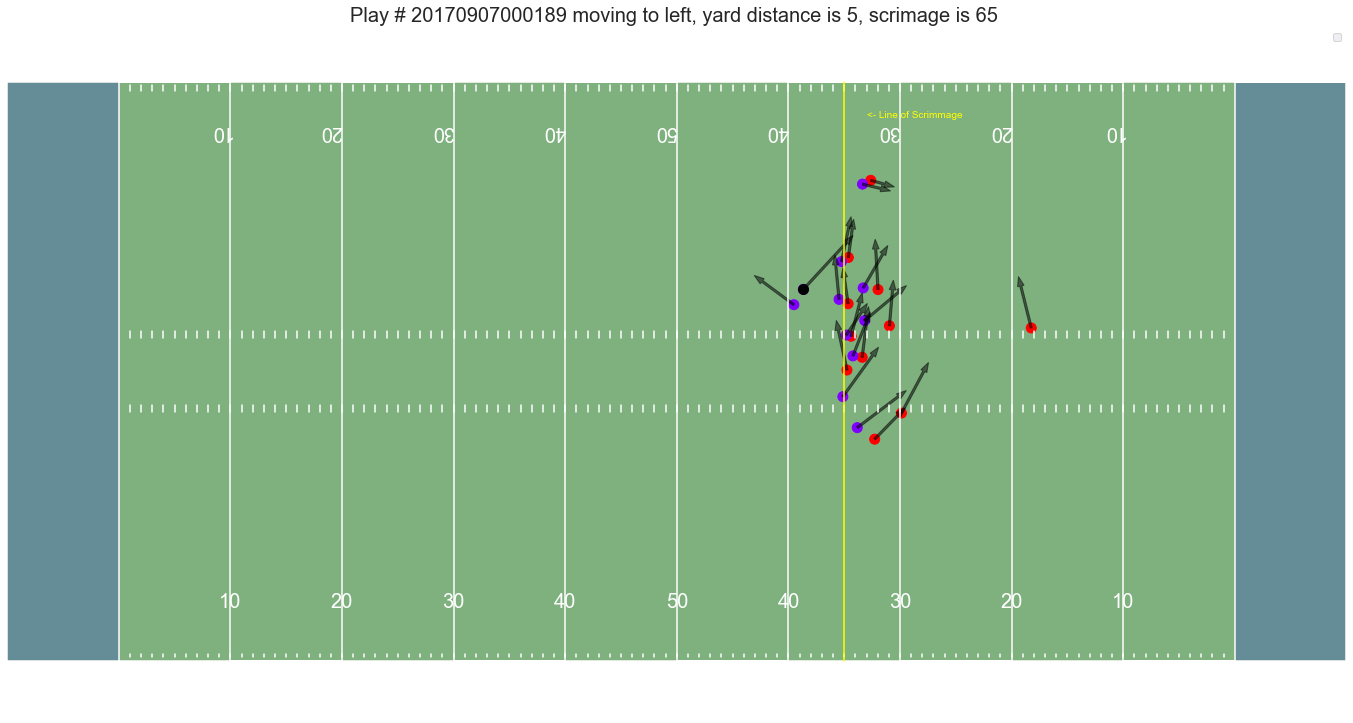

No handles with labels found to put in legend.


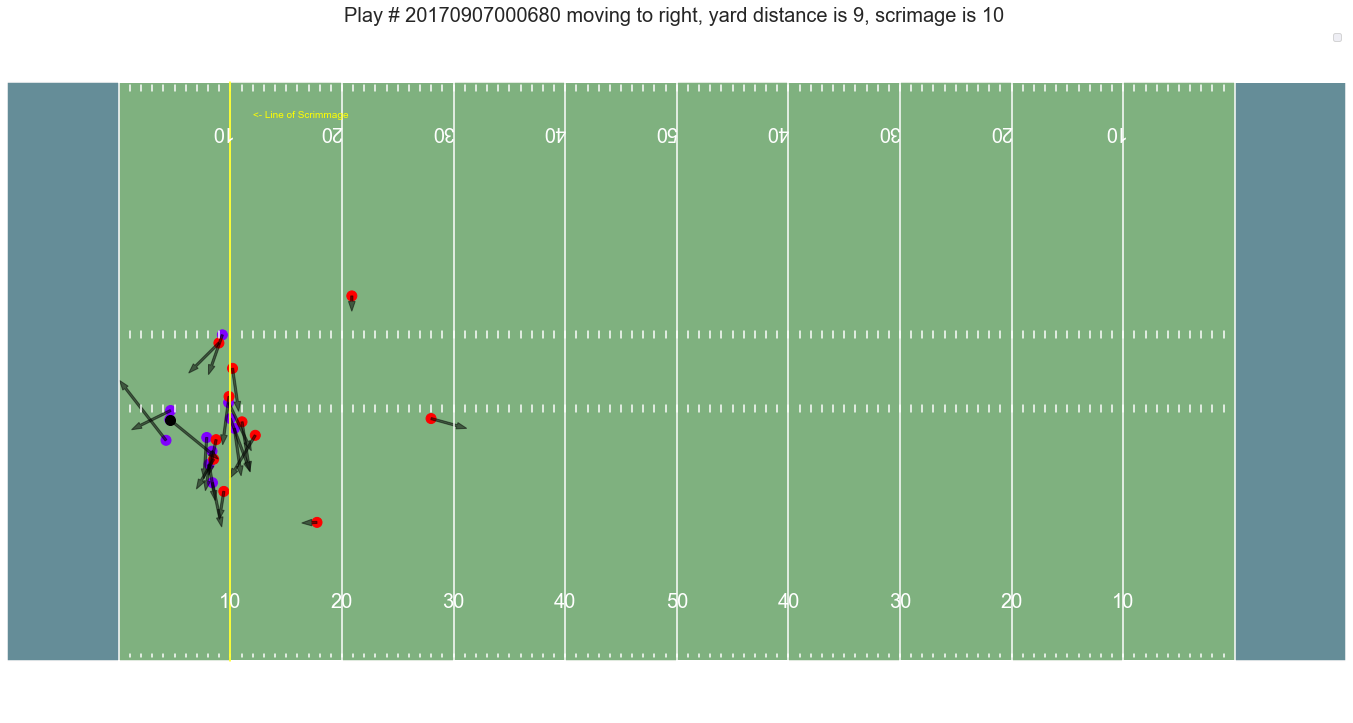

No handles with labels found to put in legend.


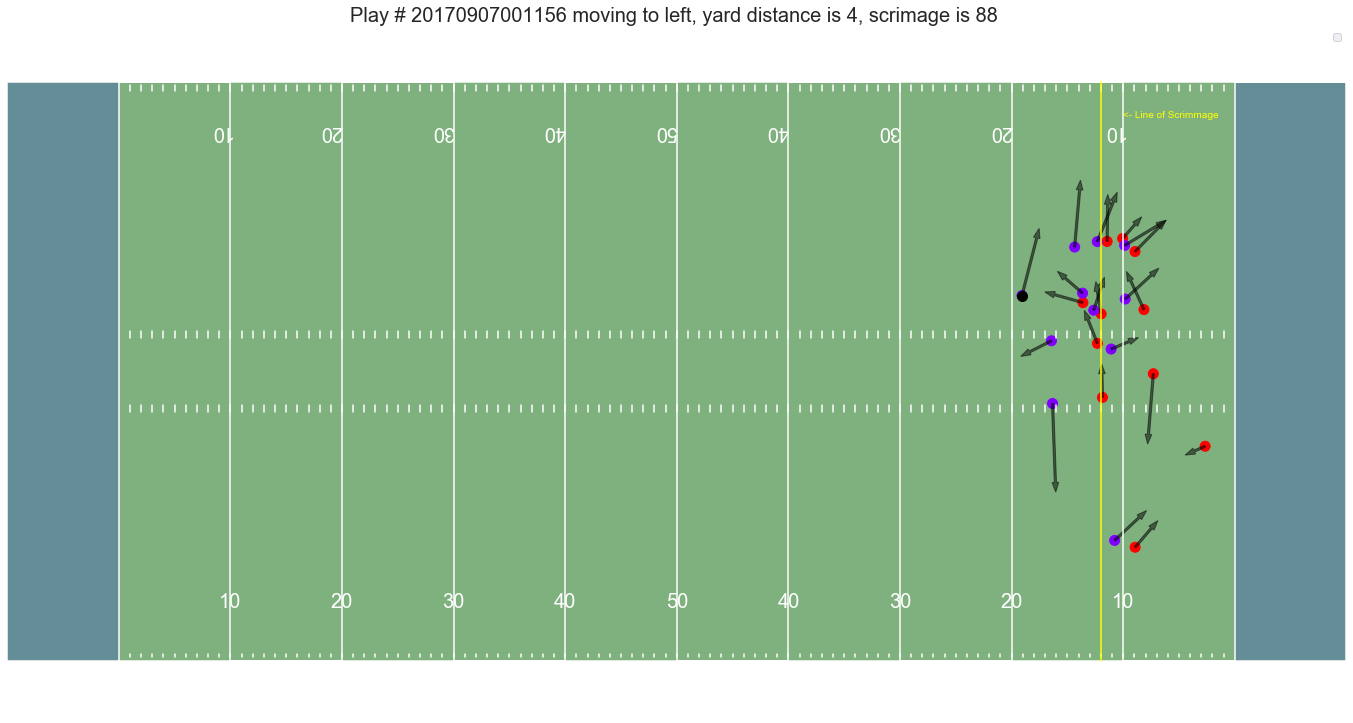

No handles with labels found to put in legend.


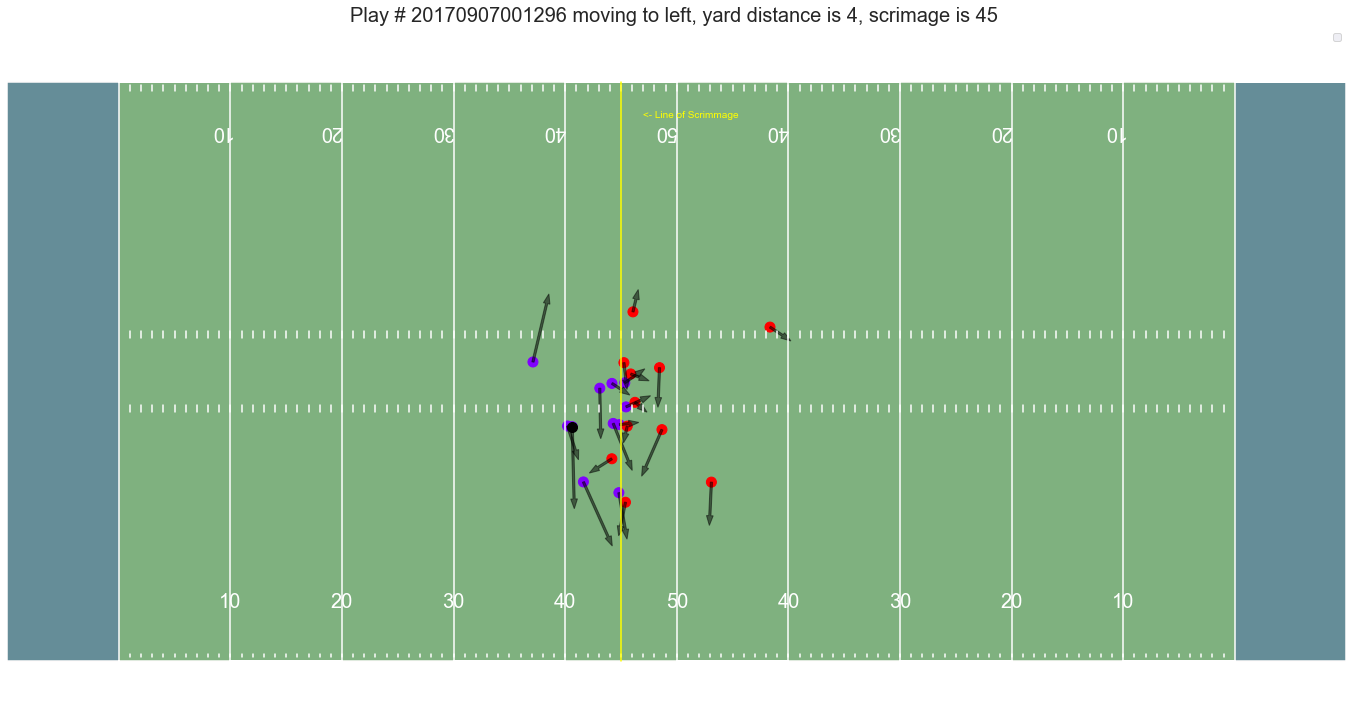

No handles with labels found to put in legend.


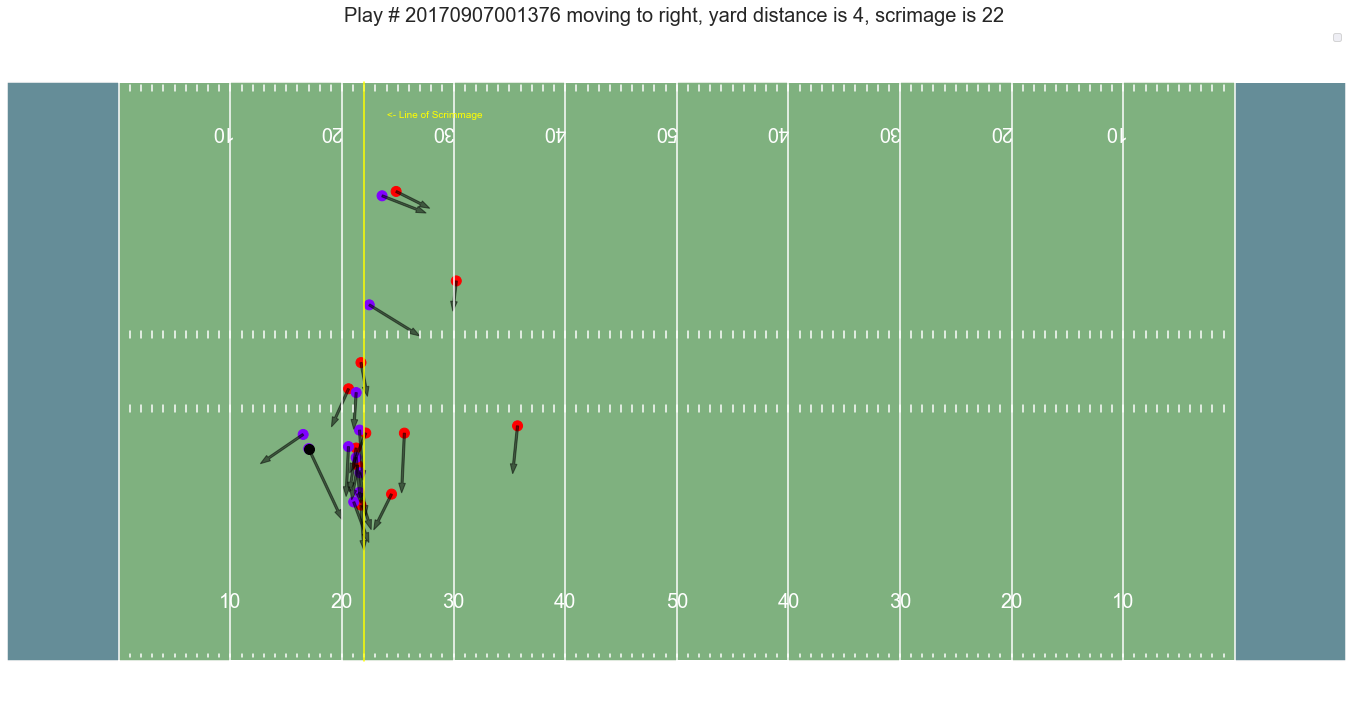

No handles with labels found to put in legend.


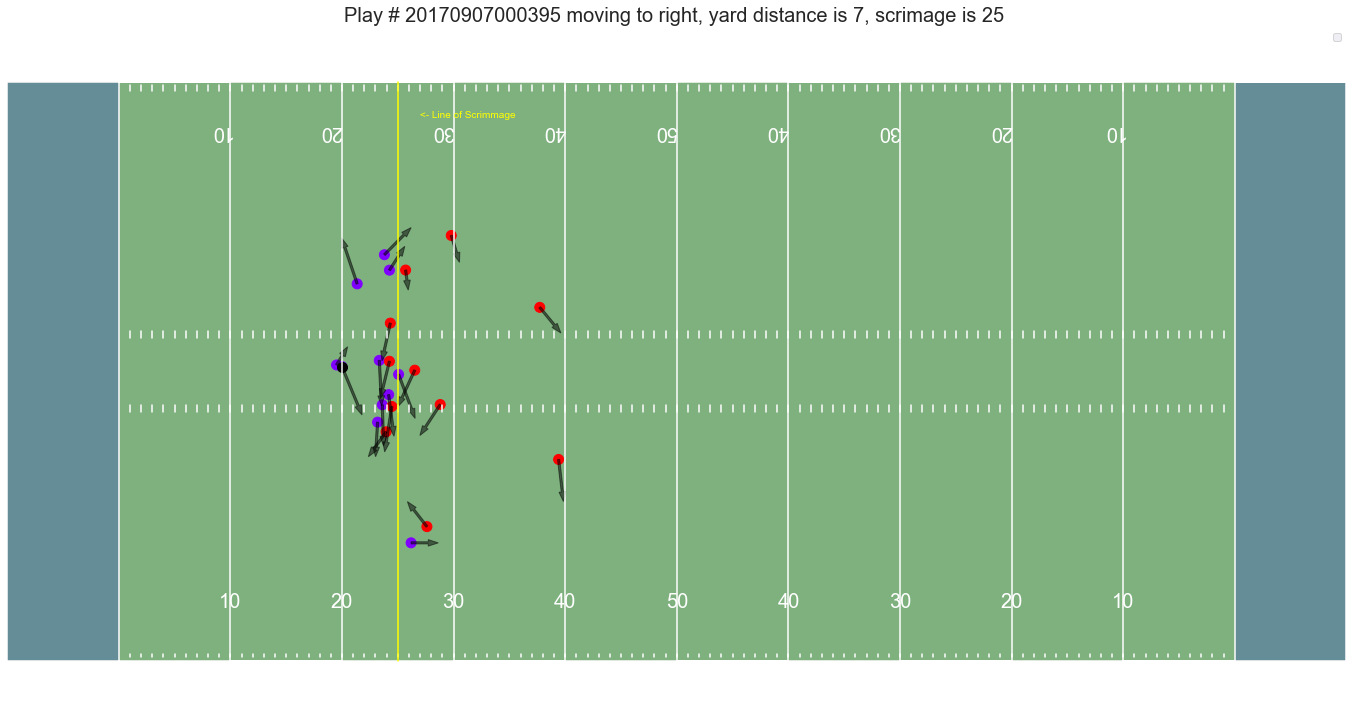

No handles with labels found to put in legend.


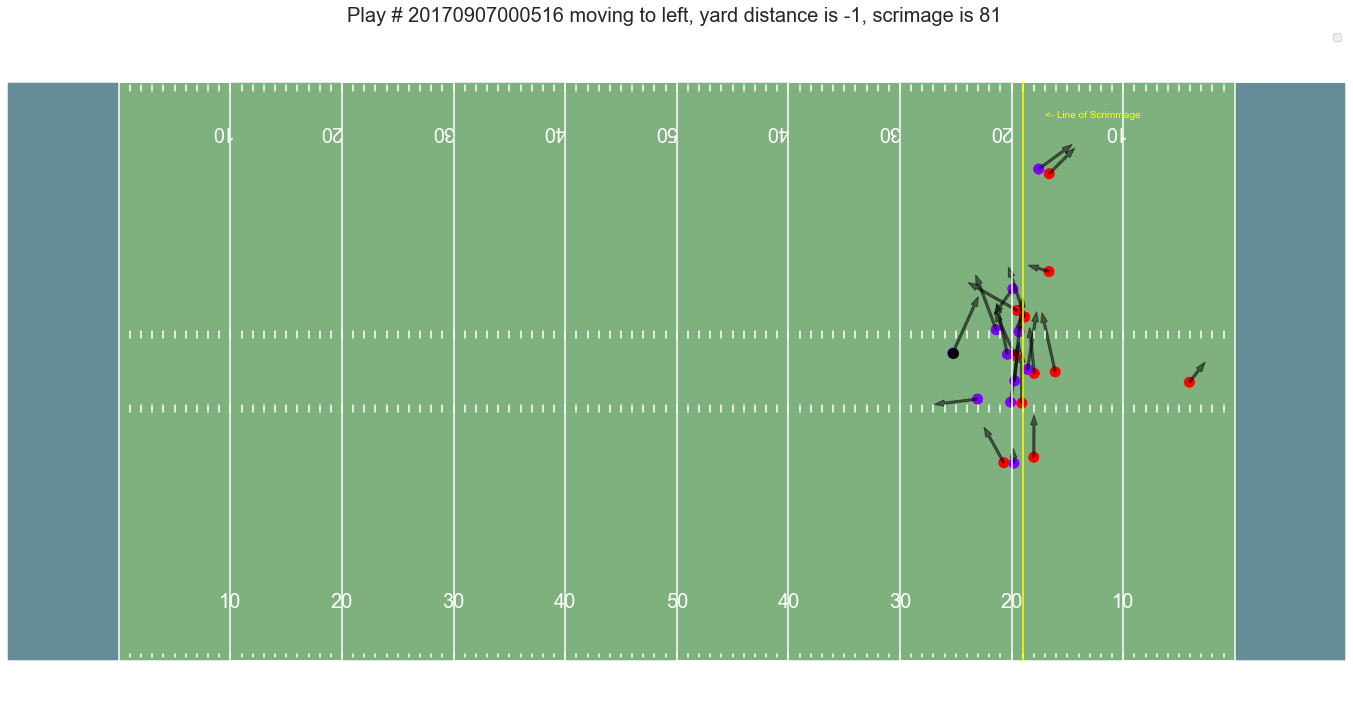

No handles with labels found to put in legend.


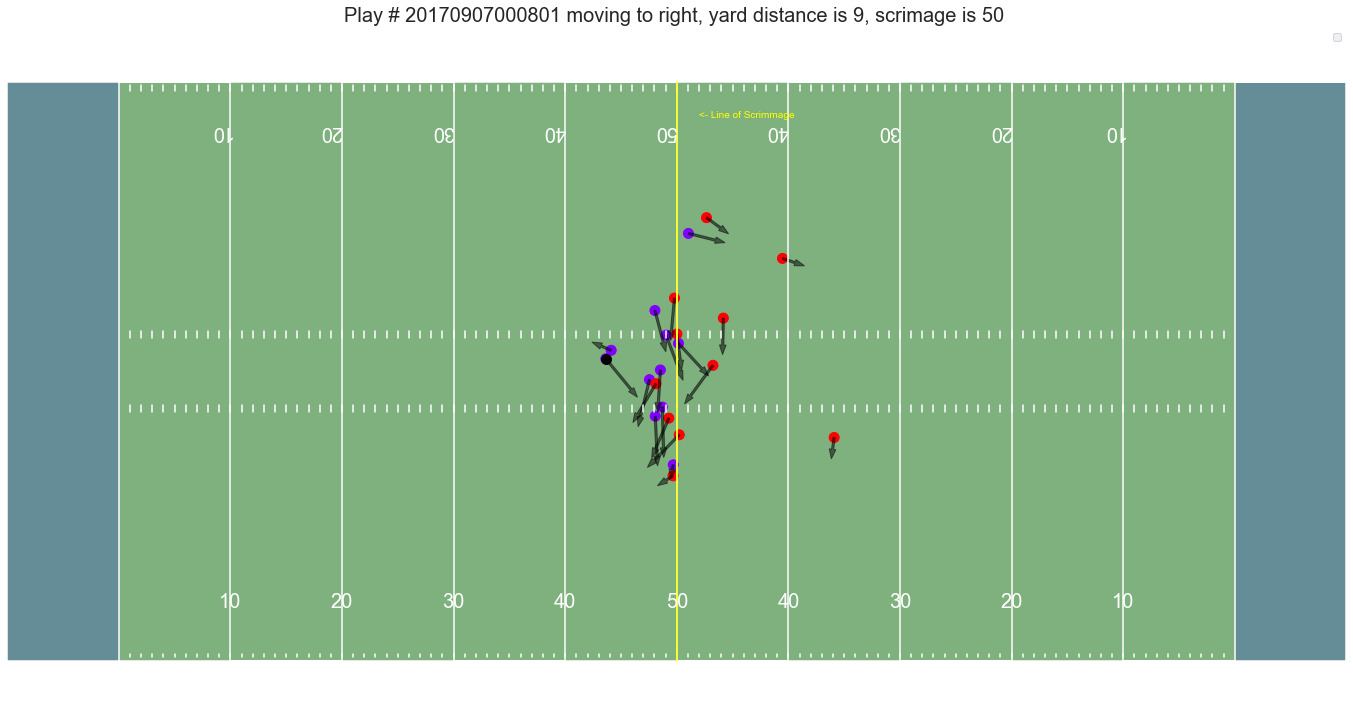

No handles with labels found to put in legend.


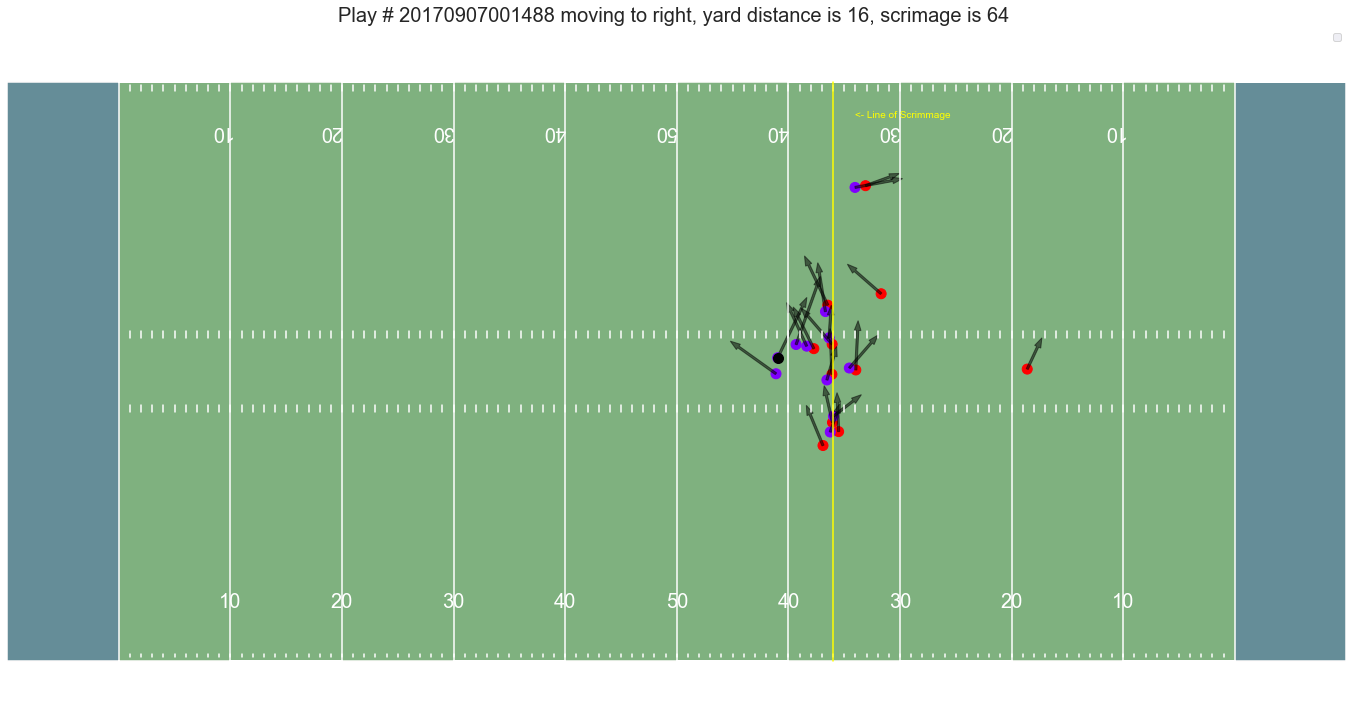

In [61]:
for play_id in outside:
    show_play_std(play_id)